## Clustering videos in vector spaces

**Aim:** Encode around 300 videos (.avi) into vector embeddings and cluster them by plotting their t-SNE reduced vectors.



In [ ]:
import os
import sys
import traceback
import cv2
from tqdm import tqdm
import numpy as np
from scipy.linalg import qr
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from scipy.linalg import qr
from torch.utils import data
from contextlib import contextmanager

# for 2D visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### Utility to normalize images



In [ ]:
imagenet_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

class ImageListDataset(data.Dataset):
    def __init__(self, image_list):
        super().__init__()
        self.image_list = image_list
        self.transform = imagenet_transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        x = self.image_list[index]
        return self.transform(x)

### Utility class to analyze and create embedding from a video

- The goal is to take 5 frames from the video, and extract features from those images using the pre-trained RESNET model which is a 512 dimensional vector.
- We then take the average of the 5 frames to create an embedding that represents our video.

In [ ]:
class VideoAnalyzer:
    def __init__(self, video):
        """
        video: cv2.VideoCapture object
        """
        self.video = video
        self.duration = self.frames = self.width = self.height = None
        _ = self.get_video_attributes(video)
        self.sampling_rate = 10
        self.n_samples = self.n_frames / self.sampling_rate
        self.n_keyframes = 5
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.frame_images = []

        # np.array of indices where the key frames are
        self.keyframe_indices = []

        # np.array of features corresponding to those key frames
        # should be a 512 x n_keyframes array
        self.keyframe_features = []

        self.thumbnail = None
        self.analyze(video)

    def set_fsize(self, fsize):
        self.fsize = fsize

    def check_constraints(self):
        """
        check if video is too big/unsupported.
        return fail=1, set appropriate error
        """
        if self.fsize > 10:
            return False, "file size larger than 10 MB not supported"
        return True, None

    def get_mean_feature(self):
        return self.keyframe_features.mean(axis=1)

    def analyze(self, video):
        self.frame_images = self.extract_frames(video)
        feature_matrix = self.extract_features(self.frame_images)
        self.keyframe_indices = self.find_keyframes(feature_matrix)
        self.keyframe_features = feature_matrix[:, self.keyframe_indices]

    def get_video_attributes(self, v):
        if self.duration is not None:
            return {
                "duration": self.duration,
                "n_frames": self.n_frames,
                "width": self.width,
                "height": self.height,
            }
        width = v.get(cv2.CAP_PROP_FRAME_WIDTH)
        height = v.get(cv2.CAP_PROP_FRAME_HEIGHT)
        v.set(cv2.CAP_PROP_POS_AVI_RATIO, 1)
        fps = v.get(cv2.CAP_PROP_FPS)
        frame_count = int(v.get(cv2.CAP_PROP_FRAME_COUNT))
        self.duration = frame_count / fps
        self.n_frames = frame_count
        self.width = width
        self.height = height
        v.set(cv2.CAP_PROP_POS_AVI_RATIO, 0)
        return {
            "duration": self.duration,
            "n_frames": self.n_frames,
            "width": self.width,
            "height": self.height,
        }

    def extract_frames(self, v):
        for i in range(self.n_frames):
            success, image = v.read()
            if image is None:
                continue
            else:
              if i % self.sampling_rate == 0:
                  pil_image = Image.fromarray(image)
                  # Save the first frame as the thumbnail for our visualization
                  if self.thumbnail is None:
                      self.thumbnail = pil_image
                  yield [pil_image]

    def extract_features(self, images, batch_size=1):
        res = []
        image_count = 0
        for img in images:
            image_count += 1
            try:
                dset = ImageListDataset(img)
                dloader = data.DataLoader(
                    dset, batch_size=batch_size, shuffle=False
                )
                feature_layer = self.model._modules.get("avgpool")

                def hook(m, i, o):
                    feature_data = o.data.reshape((512, batch_size))
                    embedding.copy_(feature_data)

                self.model.eval()
                for i, image in enumerate(dloader):
                    embedding = torch.zeros(512, batch_size)
                    h = feature_layer.register_forward_hook(hook)
                    self.model(image)
                    h.remove()
                    res.append(embedding.numpy())
            except Exception:
                print(traceback.format_exc())

        res = np.hstack(res)
        return res

    def find_keyframes(self, feature_matrix):
        Q, R, P = qr(feature_matrix, pivoting=True, overwrite_a=False)
        # Q is the orthogonal matrix that is an approximation of the featue matrix
        # P is a pivot matrix containing indices of the original (feature matrix) image vectors that have the largest vector norms
        # We select the first n indices from P to get the n keyframes
        idx = P[: self.n_keyframes]
        return idx

### Utilities to encode the video into vector embeddings using the `VideoAnalyzer` class.

In [ ]:
def getEmbedding(vid_analyzer):
    return {
        "vector": vid_analyzer.get_mean_feature().tolist(),
        "thumbnail": vid_analyzer.thumbnail,
    }

In [ ]:
def encodeVideo(fname):
    fsize = os.path.getsize(fname) / 1e6
    if fsize > 10:
        raise Exception("Video too large")

    @contextmanager
    def video_capture(fname):
        video = cv2.VideoCapture(fname)
        try:
            yield video
        finally:
            video.release()

    with video_capture(fname) as video:
        vid_analyzer = VideoAnalyzer(video)
        vid_analyzer.set_fsize(fsize)

        doable, error_msg = vid_analyzer.check_constraints()

        if not doable:
            raise Exception("Unsupported Video. Cannot index video.")

        return getEmbedding(vid_analyzer)

### The Data: [UFC101](https://www.crcv.ucf.edu/data/UCF101.php)

The dataset contains realistic action videos sourced from youtube. We will use a part of it for testing.

In [ ]:
from huggingface_hub import hf_hub_download

hf_dataset_identifier = "sayakpaul/ucf101-subset"
filename = "UCF101_subset.tar.gz"
file_path = hf_hub_download(repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset")

In [ ]:
import tarfile

with tarfile.open(file_path) as t:
     t.extractall(".")

Our dataset is divided into the following categories based on the actions:

In [ ]:
os.listdir('/content/UCF101_subset/train/')

['ApplyLipstick',
 'ApplyEyeMakeup',
 'BalanceBeam',
 'Archery',
 'BenchPress',
 'Basketball',
 'BaseballPitch',
 'BabyCrawling',
 'BasketballDunk',
 'BandMarching']

### Utilities to load all videos from the dataset
*We will only be using the training set*

In [ ]:
def load_videos(directory):
    videos = []
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith('.avi') or filename.endswith('.mp4'):
                videos.append(os.path.join(dirpath, filename))
    return videos

In [ ]:
files = load_videos('/content/UCF101_subset/train/')

### Run the encoder

Pass our videos through the encoder to generate embeddings and a thumnail frame (for visualization)..

In [ ]:
vectors = []
thumbnails = []

for file in tqdm(files):
  encoding = encodeVideo(file)
  vectors.append(encoding['vector'])
  thumbnails.append(encoding['thumbnail'])

100%|██████████| 300/300 [10:19<00:00,  2.06s/it]


### Dimensionality Reduction for visual clustering

Using the t-SNE algorithm to reduce our 512-dimension vectors into a 2-dimensional representation.

In [ ]:
X = np.array(vectors)

In [ ]:
tsne_embeddings = TSNE(n_components=2, learning_rate=150, perplexity=20, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.002s...
[t-SNE] Computed neighbors for 300 samples in 0.085s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 5.988139
[t-SNE] Computed conditional probabilities in 0.027s
[t-SNE] Iteration 50: error = 69.8628082, gradient norm = 0.3118301 (50 iterations in 0.269s)
[t-SNE] Iteration 100: error = 69.5883484, gradient norm = 0.3032443 (50 iterations in 0.252s)
[t-SNE] Iteration 150: error = 67.7342529, gradient norm = 0.3557071 (50 iterations in 0.189s)
[t-SNE] Iteration 200: error = 67.6077576, gradient norm = 0.3628764 (50 iterations in 0.142s)
[t-SNE] Iteration 250: error = 67.9391327, gradient norm = 0.3334597 (50 iterations in 0.142s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.939133
[t-SNE] Iteration 300: error = 0.7946737, gradient norm = 0.0043205 (50 iterations in 0.119s)
[t-SNE] Iteration 350: error = 0.7097790, gradient norm = 0.0047640 (

### Plot the embeddings!

We will plot a frame from the video (thumbnail) based on it's reduced t-SNE embedding.

<ipython-input-44-b7131a603bd1>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  tile = img.resize((int(img.width/rs), int(img.height/rs)), Image.ANTIALIAS)


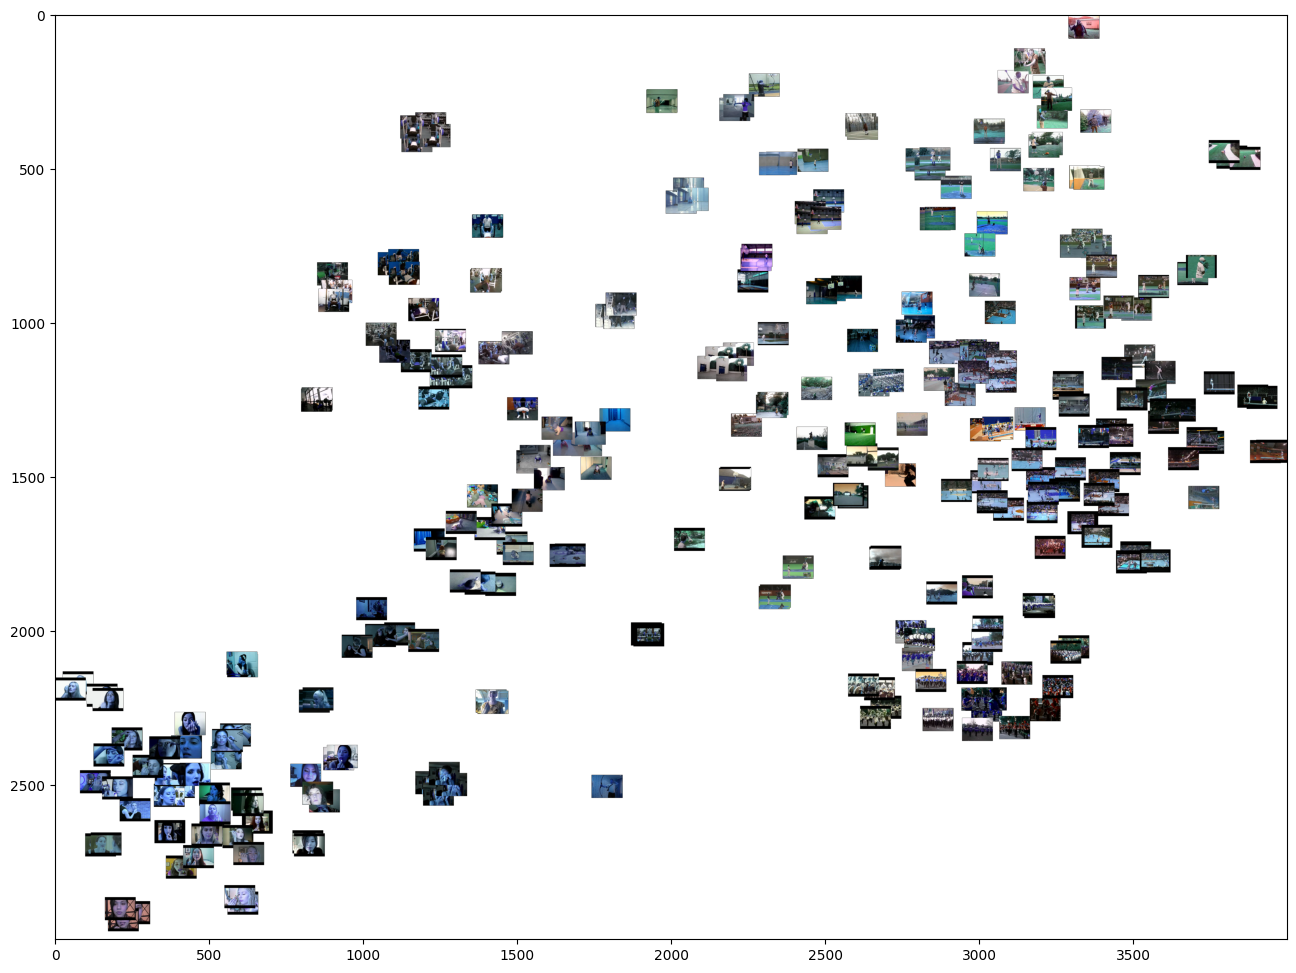

In [ ]:
tx, ty = tsne_embeddings[:,0], tsne_embeddings[:,1]

tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

width = 4000
height = 3000
max_dim = 100


full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(thumbnails, tx, ty):
    rs = max(1, img.width/max_dim, img.height/max_dim)
    tile = img.resize((int(img.width/rs), int(img.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

plt.figure(figsize = (16,12))
plt.imshow(full_image)

### Observation

- The makeup videos can be seen clustered on the bottom-left corner.
- The Gym videos can be seen clustered on the top-left corner.
- Videos with a baby crawling can be seen clustered towards the left.
- Most single person sports (like archery or just a baseball player) can be seen clustered on the top-right corner.
- Most stadium sports (like olympic sports and a baseball match) can be seen clustered towards the right.
- Band marching videos can be seen clustered at the bottom-right corner.
- Some anomalies can also be observed.

In [ ]:
full_image.save('output.png', 'PNG')